<a href="https://colab.research.google.com/github/GaneshKolt/inframind_3_edge_computing/blob/master/edge_computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing Dependencies**

In [0]:
!git clone https://github.com/GaneshKolt/inframind_3_edge_computing.git

In [0]:
!pip install pillow
!pip install lxml
!pip install Cython
!pip install jupyter
!pip install matplotlib
!pip install pandas
!pip install opencv-python
!apt-get install -qq protobuf-compiler python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive
!pip install -q pycocotools

# **Clone tensorflow models from github**

In [0]:
!git clone https://github.com/tensorflow/models/

# **Compiling proto buffers**

In [5]:
%cd models/research

/content/models/research


In [0]:
!protoc object_detection/protos/*.proto --python_out=.

## **Setting python path to /models/research folder and /models/research/slim**

In [0]:
import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

In [0]:
!python3 setup.py build
!python3 setup.py install

# **Generatin Test and train TF record**

In [0]:
%cd /content/inframind_3_edge_computing

In [0]:
!python3 generate_tfrecord.py --csv_input=data/train_labels.csv --output_path=data/train.record --image_dir=images/train

In [0]:
!python3 generate_tfrecord.py --csv_input=data/test_labels.csv --output_path=data/test.record --image_dir=images/test

# Downloading faster_rcnn_inception_v2_coco_2018_01_28 model and extracting 

In [0]:
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_v2_coco_2018_01_28.tar.gz
!tar -xvzf faster_rcnn_inception_v2_coco_2018_01_28.tar.gz
!rm -rf faster_rcnn_inception_v2_coco_2018_01_28.tar.gz

# Moving to object_detection folder 

In [0]:
!cp -r /content/inframind_3_edge_computing/data /content/models/research/object_detection
!cp -r /content/inframind_3_edge_computing/faster_rcnn_inception_v2_coco_2018_01_28 /content/models/research/object_detection
!cp -r /content/inframind_3_edge_computing/images /content/models/research/object_detection
!cp -r /content/inframind_3_edge_computing/training /content/models/research/object_detection

In [14]:
%cd /content/models/research/object_detection

/content/models/research/object_detection


# Initiating the training

In [15]:
!python3 legacy/train.py --logtostderr --train_dir=training/ --pipeline_config_path=training/faster_rcnn_inception_v2_coco.config

INFO:tensorflow:global step 24317: loss = 0.0382 (0.166 sec/step)
I1002 11:05:27.852828 139691910813568 learning.py:507] global step 24317: loss = 0.0382 (0.166 sec/step)
INFO:tensorflow:global step 24318: loss = 0.0436 (0.168 sec/step)
I1002 11:05:28.022443 139691910813568 learning.py:507] global step 24318: loss = 0.0436 (0.168 sec/step)
INFO:tensorflow:global step 24319: loss = 0.0545 (0.170 sec/step)
I1002 11:05:28.193289 139691910813568 learning.py:507] global step 24319: loss = 0.0545 (0.170 sec/step)
INFO:tensorflow:global step 24320: loss = 0.1596 (0.168 sec/step)
I1002 11:05:28.362206 139691910813568 learning.py:507] global step 24320: loss = 0.1596 (0.168 sec/step)
INFO:tensorflow:global step 24321: loss = 0.0500 (0.158 sec/step)
I1002 11:05:28.521995 139691910813568 learning.py:507] global step 24321: loss = 0.0500 (0.158 sec/step)
INFO:tensorflow:global step 24322: loss = 0.0714 (0.166 sec/step)
I1002 11:05:28.689245 139691910813568 learning.py:507] global step 24322: loss 

# **Exporting the Inference graph and creting the model**

In [0]:
!python3 export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path training/faster_rcnn_inception_v2_coco.config \
    --trained_checkpoint_prefix training/model.ckpt-24124 \
    --output_directory edge_computing_model

# **Testing Number plate detection**

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

In [0]:
# This is needed to display the images.
%matplotlib inline

In [0]:
from utils import label_map_util

from utils import visualization_utils as vis_util

In [0]:

# What model to download.
MODEL_NAME = 'edge_computing_model'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('training', 'object-detection.pbtxt')

In [0]:

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [37]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, '{}.jpg'.format(i)) for i in range(1, 5) ]
print(TEST_IMAGE_PATHS)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

['test_images/1.jpg', 'test_images/2.jpg', 'test_images/3.jpg', 'test_images/4.jpg']


In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

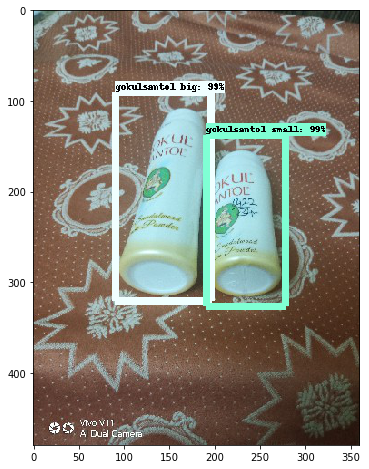

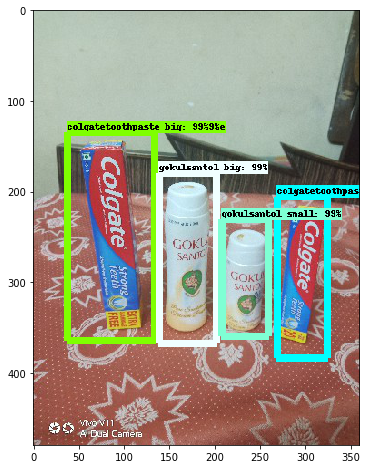

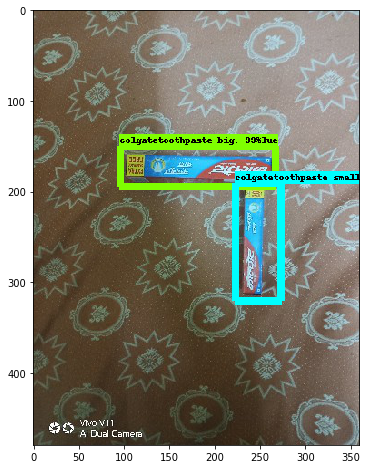

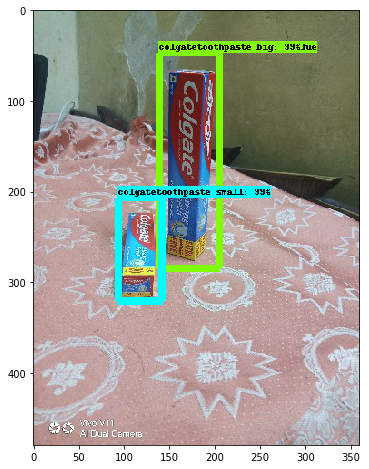

In [39]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [42]:
!zip -r trained_model.zip edge_computing_model

  adding: edge_computing_model/ (stored 0%)
  adding: edge_computing_model/model.ckpt.index (deflated 70%)
  adding: edge_computing_model/model.ckpt.meta (deflated 94%)
  adding: edge_computing_model/pipeline.config (deflated 66%)
  adding: edge_computing_model/checkpoint (deflated 42%)
  adding: edge_computing_model/model.ckpt.data-00000-of-00001 (deflated 7%)
  adding: edge_computing_model/saved_model/ (stored 0%)
  adding: edge_computing_model/saved_model/saved_model.pb (deflated 9%)
  adding: edge_computing_model/saved_model/variables/ (stored 0%)
  adding: edge_computing_model/frozen_inference_graph.pb (deflated 9%)
